In [1]:
from joblib import dump, load
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
from dateutil.parser import parse
from IPython.display import display, HTML
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
from nltk import ngrams
from collections import Counter
import numpy as np
import string as string_
from multiprocessing import Pool, cpu_count
from tqdm import tqdm_notebook
import tempfile
import warnings
import eli5

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
CORES = cpu_count()

# Data Extraction

In [2]:
df = pd.read_csv(filepath_or_buffer = "training.1600000.processed.noemoticon.csv", 
                 encoding = "ISO-8859-1", 
                 names = ["sentiment", "ids", "date", "flag", "user", "text"])

In [3]:
df.shape

(1600000, 6)

In [4]:
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [5]:
df.tail()

,sentiment,ids,date,flag,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H


# Initial Data Cleaning

#### Change labels to binary format

In [47]:
df.sentiment.replace({4:1}, inplace=True)

In [48]:
# 1 = positive
# 0 = negative

df.sentiment.value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

#### Extract Dates for analysis

In [49]:
# date functions
month_map = {
    "Jan":"01",
    "Feb":"02",
    "Mar":"03",
    "Apr":"04",
    "May":"05",
    "Jun":"06",
    "Jul":"07",
    "Aug":"08",
    "Sep":"09",
    "Oct":"10",
    "Nov":"11",
    "Dec":"12",
}

def extract_year(string):
    return re.search('(\d{4})', string).group()

def extract_time(string):
    return re.search('(?:[01]\d|2[0123]):(?:[012345]\d):(?:[012345]\d)', string).group()

def extract_day(string):
    return string.split()[0]

def extract_date(string, month_map = month_map):    
    year = extract_year(string)
    date = string.split()[:3]
    return year + '-' + month_map[date[1]] + '-' + date[2]

def extract_datetime(string, month_map = month_map):
    date = extract_date(string)
    time = extract_time(string)
    return date + " " + time

In [50]:
df.rename(index=str, columns={"date":"date_old"}, inplace=True)

df['datetime'] = df.date_old.apply(lambda x: extract_datetime(x))
df['time'] = df.date_old.apply(lambda x: extract_time(x))
df['date'] = df.date_old.apply(lambda x: extract_date(x))
df['day']  = df.date_old.apply(lambda x: extract_day(x))

df.drop(['date_old', 'flag', 'ids'], axis=1, inplace=True)

In [51]:
df.head()

,sentiment,user,text,datetime,time,date,day
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",2009-04-06 22:19:45,22:19:45,2009-04-06,Mon
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,2009-04-06 22:19:49,22:19:49,2009-04-06,Mon
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,2009-04-06 22:19:53,22:19:53,2009-04-06,Mon
3,0,ElleCTF,my whole body feels itchy and like its on fire,2009-04-06 22:19:57,22:19:57,2009-04-06,Mon
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",2009-04-06 22:19:57,22:19:57,2009-04-06,Mon


# Data Exploration

#### At first glance, with uncleaned raw text, we have a vocabulary of over 1.19 million unique words, although this includes strings that will later be removed, including usernames, urls, words attached to punctuation and so on.  

In [52]:
len(set(df['text'].str.cat(sep=' ').lower().split()))

1193584

#### The average length of each tweet is around 13 words

In [53]:
sum([len(sentence.split()) for sentence in df.text]) / df.shape[0]

13.176150625

#### Tweets are between  April 6, 2009 to June 25, 2009.

In [54]:
df.datetime.min(), df.datetime.max()

('2009-04-06 22:19:45', '2009-06-25 10:28:31')

#### We can split the data into each sentiment group, to see if there are any noticable distinguishments that could help us in the later stages of feature selection, engineering and cleaning.

In [55]:
df_pos = df[df.sentiment==1]
df_neg = df[df.sentiment==0]

#### Looking and the number of tweets for both sentiment classes for each day of the week, we can see that positive tweets seem to occur less on wednesdays and thursdays, and more on a mondays and sundays. Negative tweets seem more evenly distributed, with slight increases across the weekends. However, this could be caused by the methods of data collection.

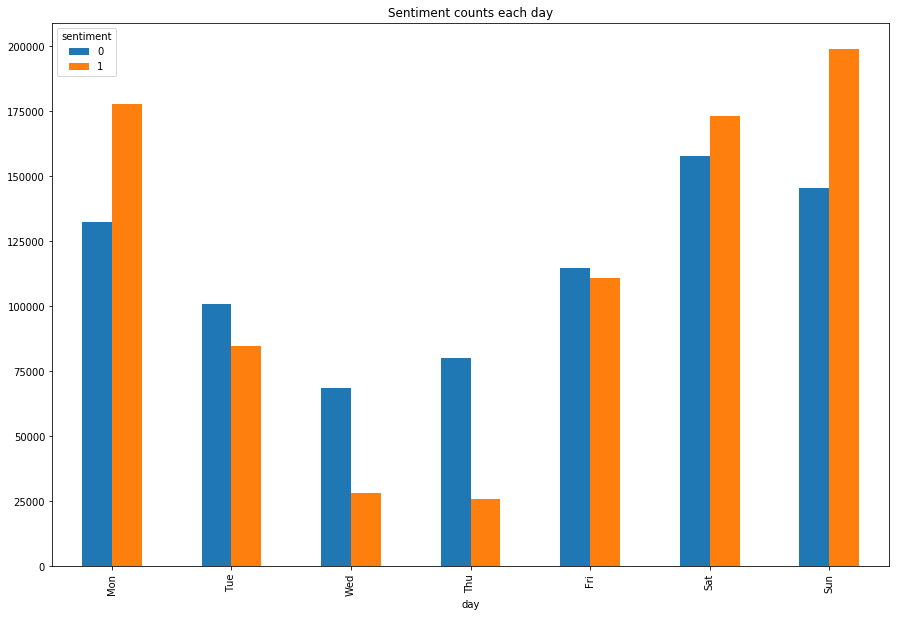

In [56]:
index=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
pd.crosstab(df['day'],df['sentiment']).reindex(index).plot.bar(title='Sentiment counts each day', figsize=(15, 10))

#### Looking at the time each sentiment class occurs does not provide much valuable information.

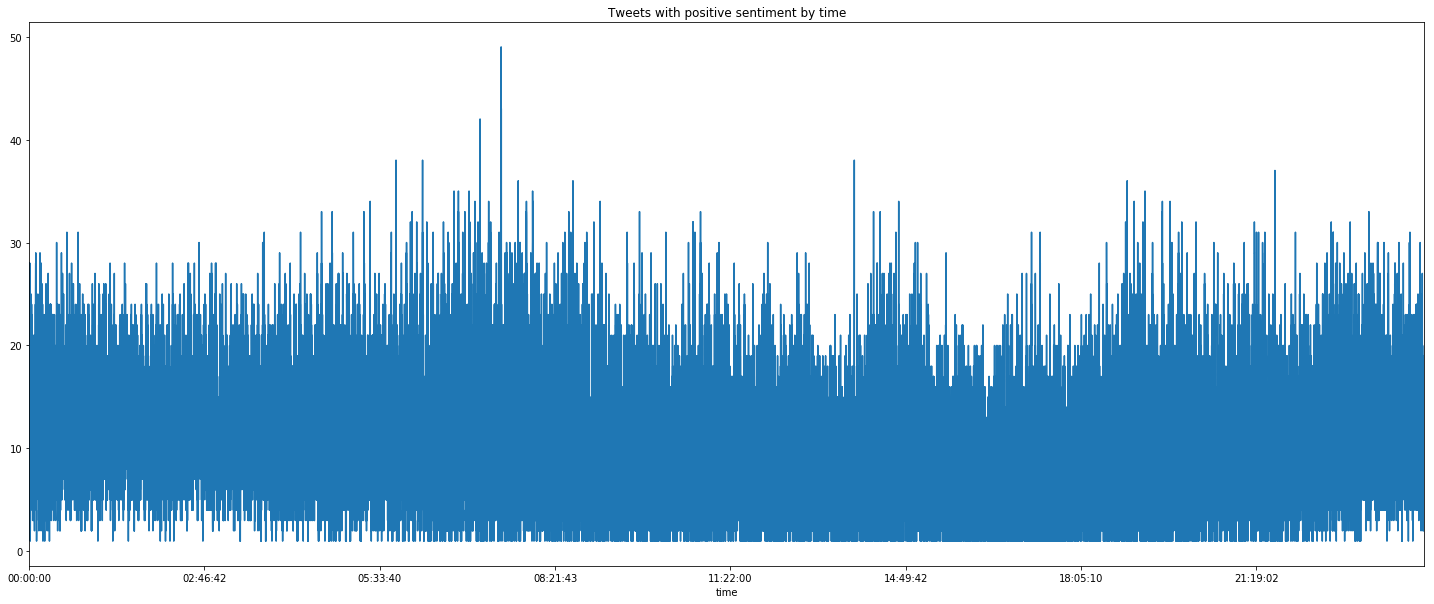

In [57]:
df_pos.groupby('time').sentiment.count().plot(figsize=(25, 10), title='Tweets with positive sentiment by time')

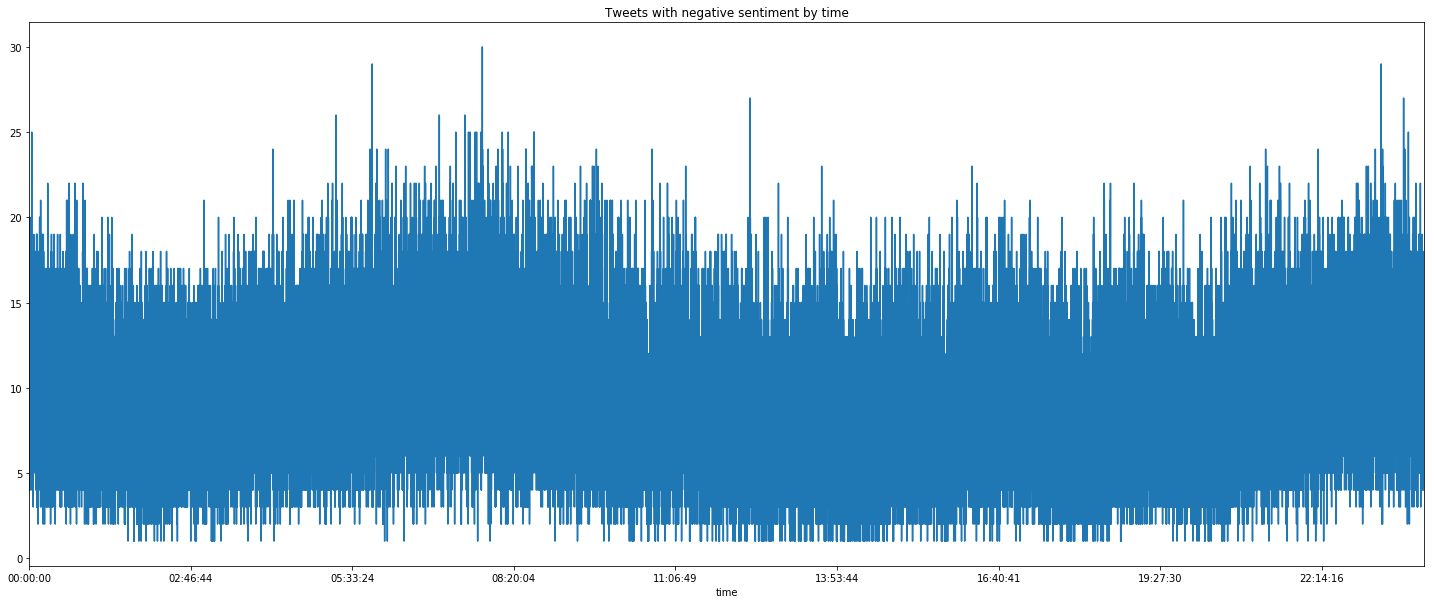

In [58]:
df_neg.groupby('time').sentiment.count().plot(figsize=(25, 10), title='Tweets with negative sentiment by time')

In [59]:
def get_wordcloud(text, custom_stopwords = None):
    if custom_stopwords: custom_stopwords = list(STOPWORDS) + custom_stopwords
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = custom_stopwords if custom_stopwords else STOPWORDS).generate(str(text))
    fig = plt.figure(
        figsize = (30, 20),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

####  Wordclouds for both classes (pre-cleaning) give some valuable insight. Words such as 'congrats', 'thanks', 'best' and 'love' appear in the positive sentiment tweets...

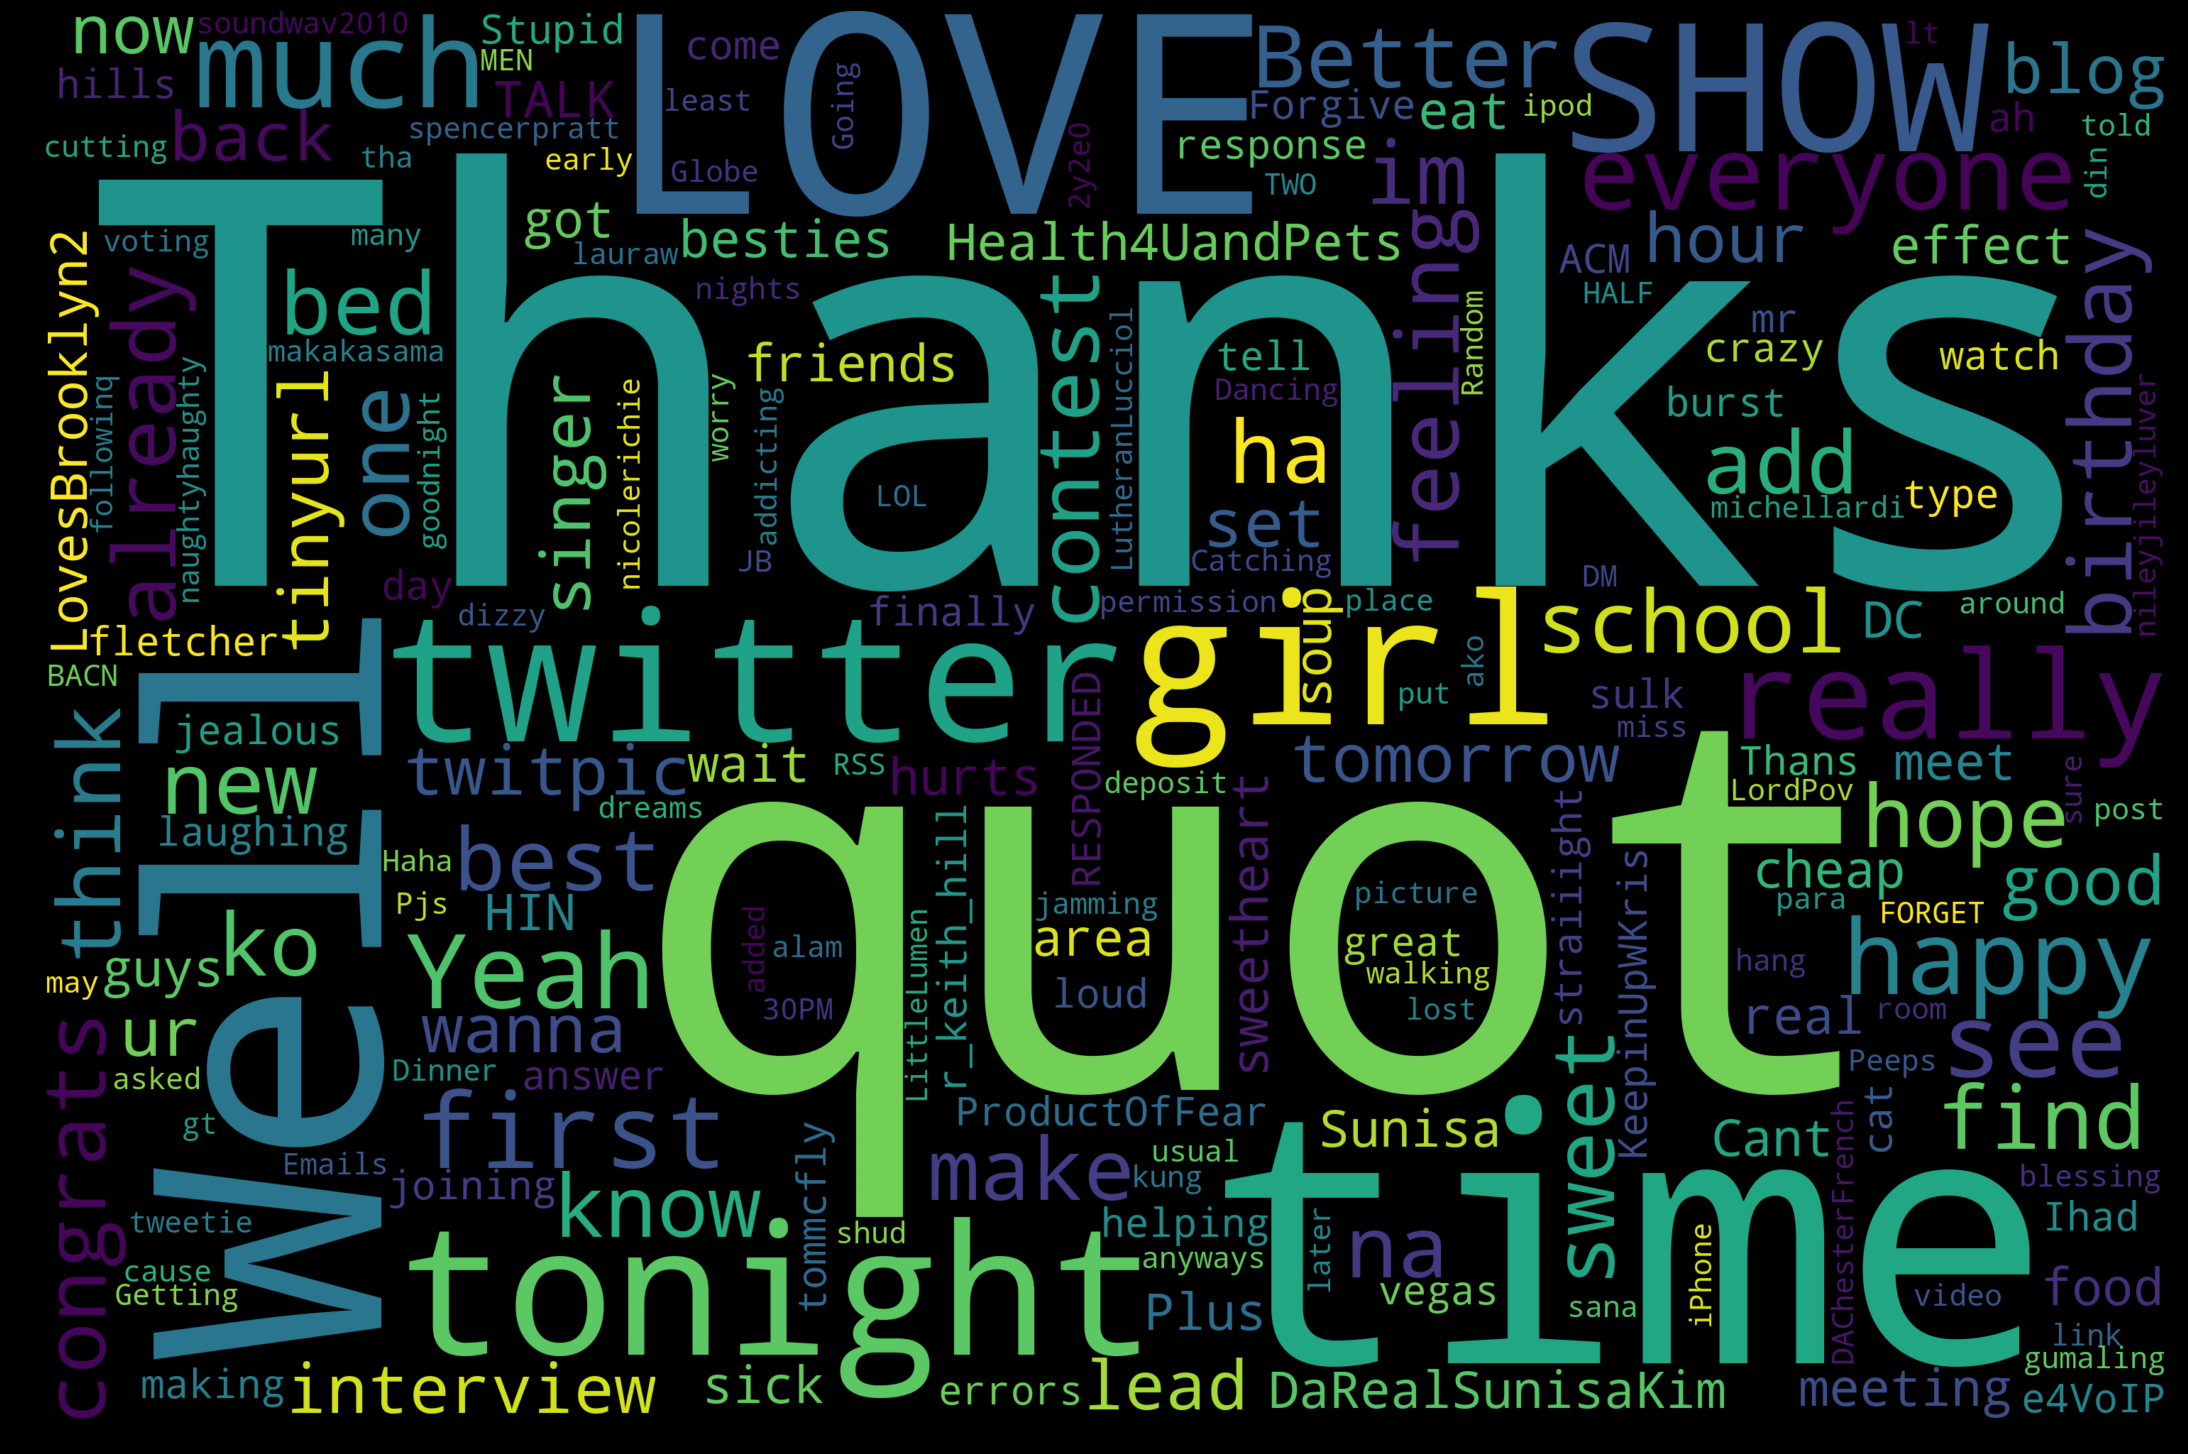

In [60]:
get_wordcloud(df_pos.text)

#### ...and words from the negative sentiment tweets' wordcloud include 'RIP', 'Sad' and 'ugh'

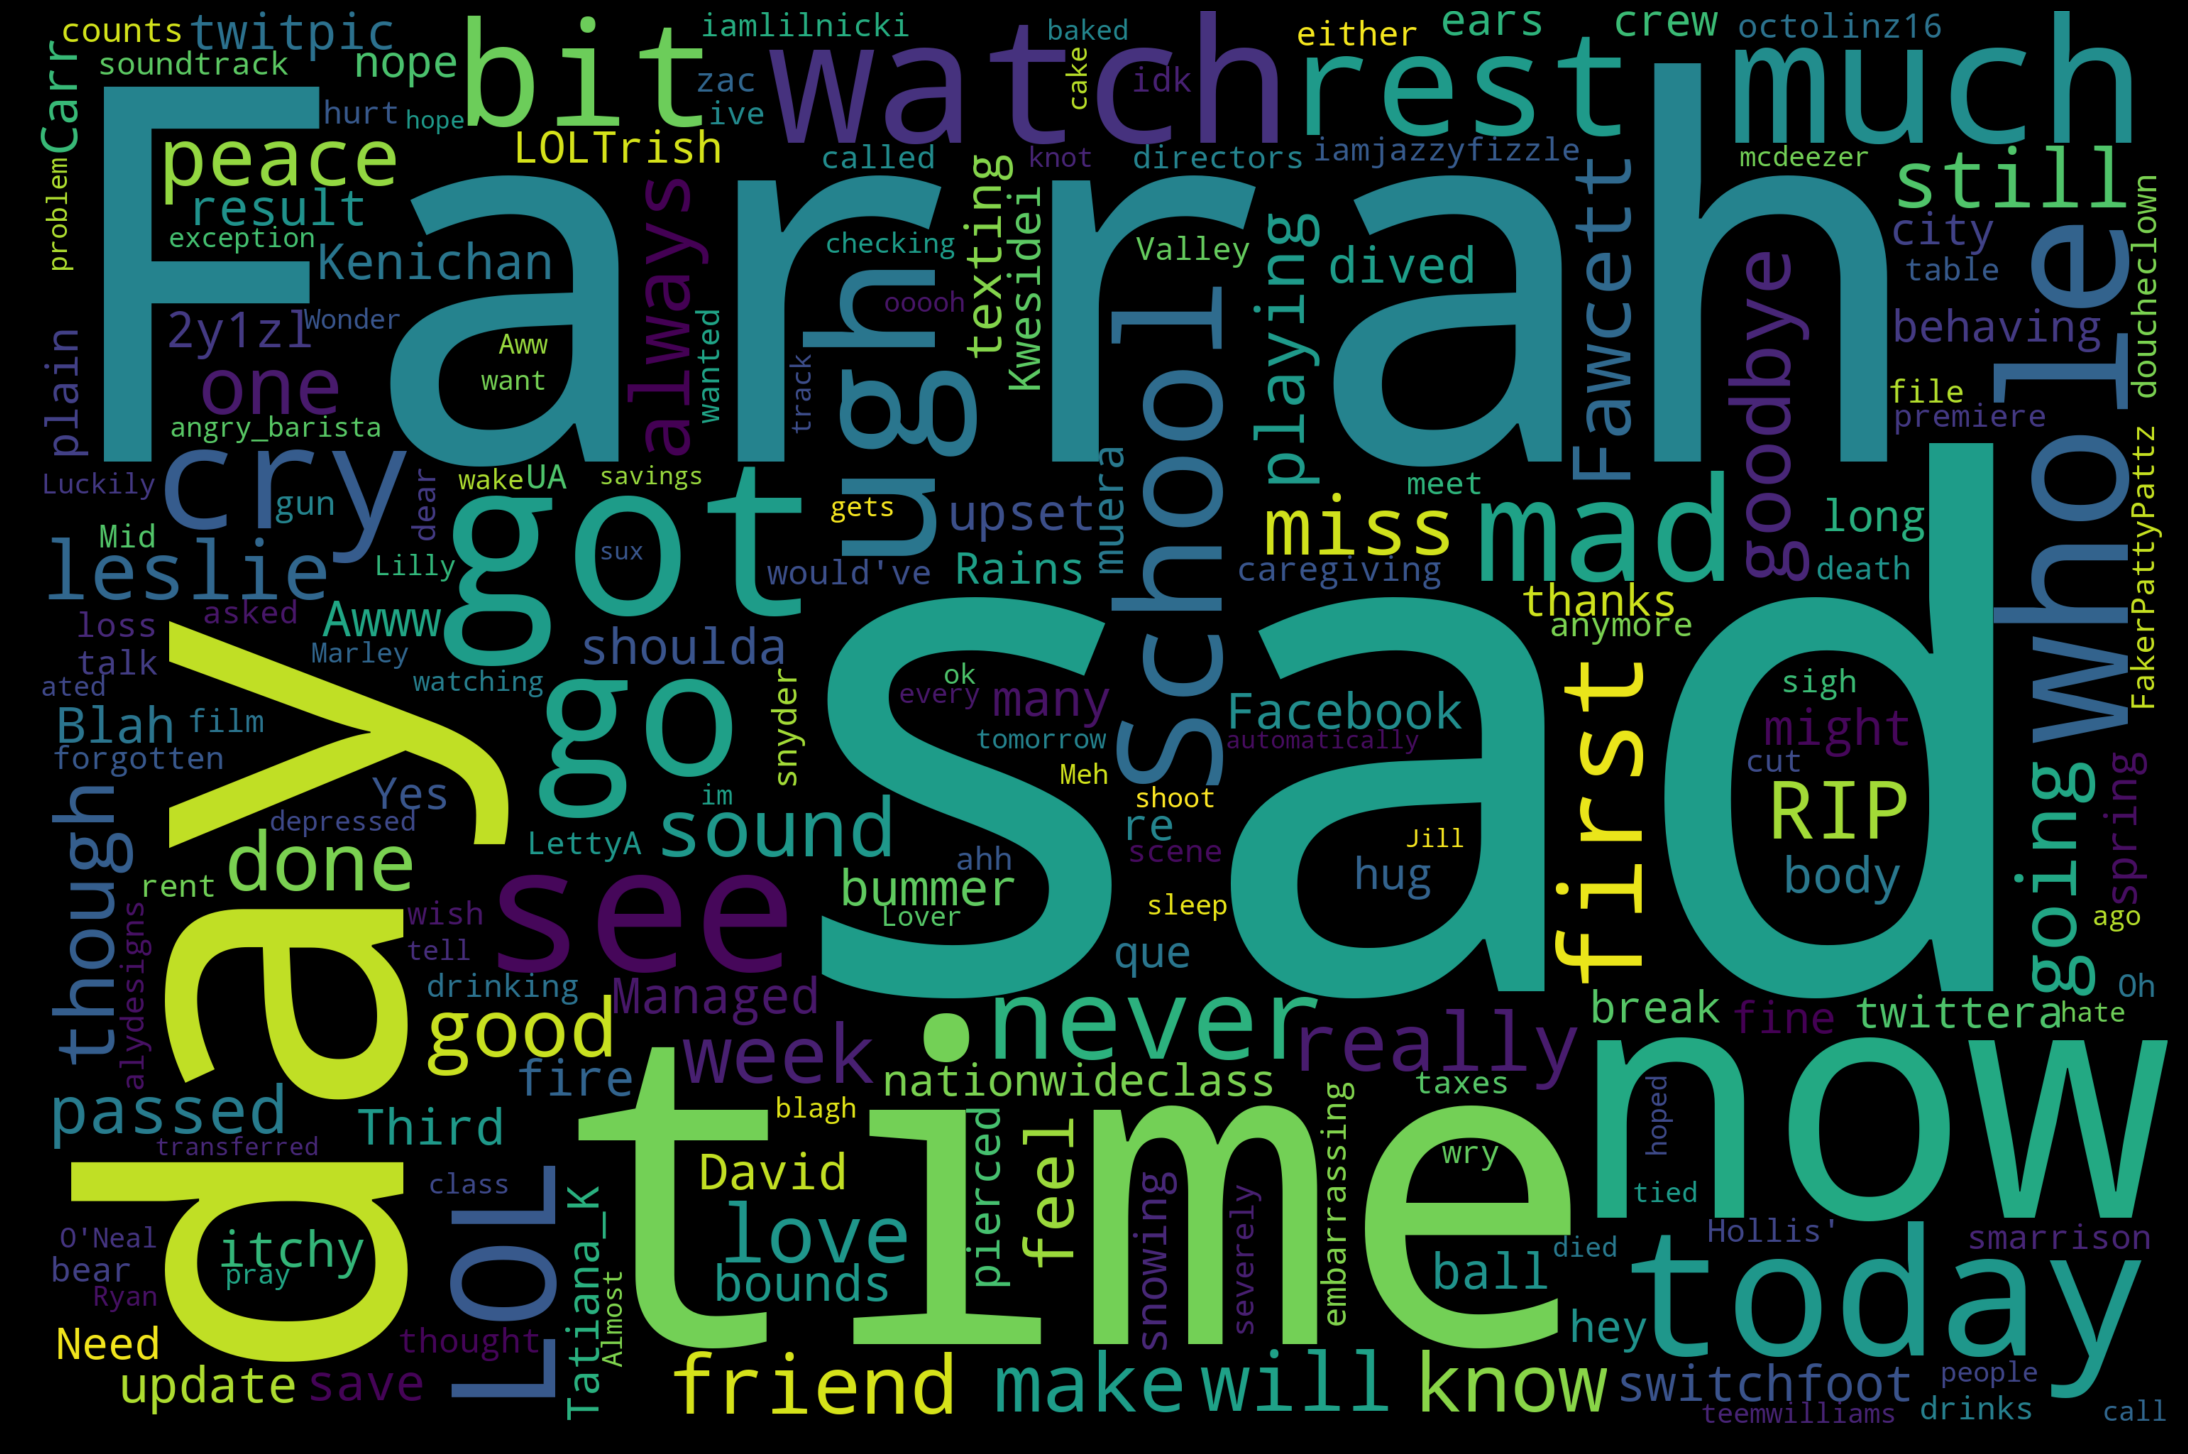

In [61]:
get_wordcloud(df_neg.text)

# Text processing

In [62]:

def clean_text(df):

    df['clean_text'] = df.text.apply(lambda x: x.lower()) # lower case
    df['clean_text'] = df.clean_text.apply(lambda x: re.sub(r"http\S+", "", x)) # remove url
    df['clean_text'] = df.clean_text.apply(lambda x: re.sub('@[^\s]+','', x)) # remove usernames
    df['clean_text'] = df.clean_text.apply(lambda x: re.sub(r'#([^\s]+)', r'\1', x)) # remove # from hashtag
    df['clean_text'] = df.clean_text.apply(lambda x: x.translate(str.maketrans('', '', string_.punctuation))) # remove punctuation
    df['clean_text'] = df.clean_text.apply(lambda x: re.sub(' +', ' ', x.strip())) # remove trailing and double whitespace
    df['clean_text'] = df.clean_text.apply(lambda x: ' '.join(word for word in x.split() if word not in stopwords.words('english'))) # remove stopwords
    
    return df

##### Apply text cleaning function to dataframe and remove rows with less than 1 word remaining 

In [63]:
def apply_clean_text_to_row(df):
    return clean_text(df)

def parallelize_clean_text(df, func, n_cores):
    df_split = np.array_split(df, n_cores)
    with Pool(n_cores) as p:
        df = pd.concat(p.map(func, df_split))
    return df

In [3]:
if not os.path.isfile("df_clean.csv"):
    df = parallelize_clean_text(df, apply_clean_text_to_row, CORES)
    df.to_csv("df_clean.csv", index=False)
else:
    df = pd.read_csv("df_clean.csv")

In [4]:
df = df[df.clean_text.str.split().str.len() > 1]
df.reset_index(drop=True)
df.head()

,sentiment,user,text,datetime,time,date,day,clean_text
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",2009-04-06 22:19:45,22:19:45,2009-04-06,Mon,awww thats bummer shoulda got david carr third day
1,0,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,2009-04-06 22:19:49,22:19:49,2009-04-06,Mon,upset cant update facebook texting might cry result school today also blah
2,0,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,2009-04-06 22:19:53,22:19:53,2009-04-06,Mon,dived many times ball managed save 50 rest go bounds
3,0,ElleCTF,my whole body feels itchy and like its on fire,2009-04-06 22:19:57,22:19:57,2009-04-06,Mon,whole body feels itchy like fire
4,0,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",2009-04-06 22:19:57,22:19:57,2009-04-06,Mon,behaving im mad cant see


In [8]:
df.shape

(1545489, 8)

## Modelling with TFIDF Vectorizer 

#### Split the data into its training and testing subsets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.clean_text, df.sentiment, test_size = 0.2, random_state = 0)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1236391,)
y_train shape: (1236391,)
X_test shape: (309098,)
y_test shape: (309098,)


#### Create a simple baseline model using multinomial naive bayes

In [10]:
tfidf_args = {
    'ngram_range': (1, 2),
    'use_idf': True,
    'sublinear_tf': False,
}

pipe_nb = Pipeline([
    ('vectorizer', TfidfVectorizer(**tfidf_args)),
    ('classifier', MultinomialNB())
])

nb_path = "nb_pipe.sav"
if not os.path.isfile(nb_path):
    best_nb_pipe = pipe_nb.fit(X_train, y_train)
    dump(pipe_nb, nb_path) 
else:
    best_nb_pipe = load(nb_path) 
print(classification_report(y_test, best_nb_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.77      0.82      0.79    155303
           1       0.80      0.75      0.78    153795

    accuracy                           0.78    309098
   macro avg       0.79      0.78      0.78    309098
weighted avg       0.79      0.78      0.78    309098



#### Create a simple pipeline for to vectorize the text and classify using logistic regression

In [43]:
pipe_logit = Pipeline([
    ('vectorizer', TfidfVectorizer(**tfidf_args)),
    ('classifier', LogisticRegression())
], memory=tempfile.gettempdir())


param_grid_logit = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C':[.1, 1, 10]
}
    
gs_logit = GridSearchCV(pipe_logit, param_grid_logit, n_jobs=9, cv=3, verbose=10, scoring='accuracy')

In [44]:
logit_path = "logit_pipe.sav"
if not os.path.isfile(logit_path):
    best_logit_pipe = gs_logit.fit(X_train, y_train)
    dump(best_logit_pipe.best_estimator_, logit_path) 
else:
    best_logit_pipe = load(logit_path)

In [45]:
print(classification_report(y_test, best_logit_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80    155303
           1       0.80      0.80      0.80    153795

    accuracy                           0.80    309098
   macro avg       0.80      0.80      0.80    309098
weighted avg       0.80      0.80      0.80    309098



#### Create a simple pipeline for to vectorize the text and classify using a linear support vector classifier

In [14]:
pipe_svc = Pipeline([
    ('vectorizer', TfidfVectorizer(**tfidf_args)),
    ('classifier', LinearSVC())
], memory=tempfile.gettempdir())


param_grid_svc = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C':[.1, 1, 10],
    'classifier__dual':[True, False]
}
    
gs_svc = GridSearchCV(pipe_svc, param_grid_svc, n_jobs=12, cv=3, verbose=3, scoring='accuracy', error_score=0.0)

In [15]:
svc_path = "svc_pipe.sav"
if not os.path.isfile(svc_path):
    best_svc_pipe = gs_svc.fit(X_train, y_train)
    dump(best_svc_pipe.best_estimator_, svc_path) 
else:
    best_svc_pipe = load(svc_path)

In [16]:
print(classification_report(y_test, best_svc_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80    155303
           1       0.80      0.80      0.80    153795

    accuracy                           0.80    309098
   macro avg       0.80      0.80      0.80    309098
weighted avg       0.80      0.80      0.80    309098



#### Roc curves

In [80]:
nb_probas = best_nb_pipe.predict_proba(X_test)[:, 1]
logit_probas = best_logit_pipe.predict_proba(X_test)[:, 1]
svc_decision_func = best_svc_pipe.decision_function(X_test)

In [81]:
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, nb_probas)
fpr_logit, tpr_logit, thresholds_logit= roc_curve(y_test, logit_probas)
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, svc_decision_func)

In [104]:
nb_auc = np.round(roc_auc_score(y_test, nb_probas), 2)
logit_auc = np.round(roc_auc_score(y_test, logit_probas), 2)
svc_auc = np.round(roc_auc_score(y_test, svc_decision_func), 2)

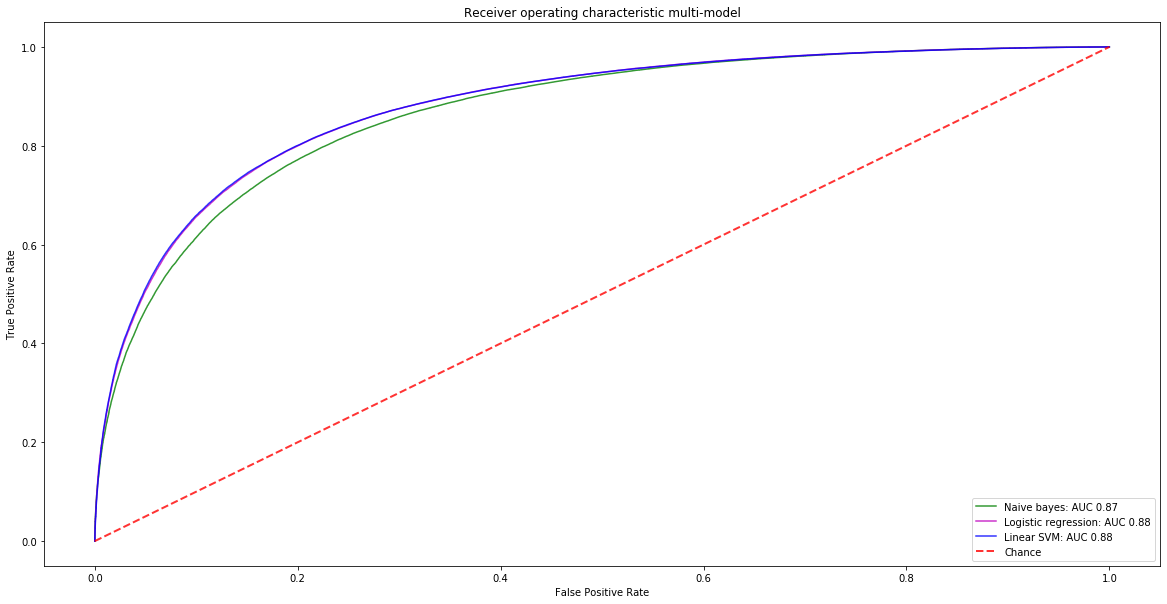

In [107]:
%matplotlib inline
plt.figure(figsize = (20,10))
plt.plot(fpr_nb, tpr_nb, color='g', label=f'Multinomial naive bayes: AUC {nb_auc}', alpha=.8)
plt.plot(fpr_logit, tpr_logit, color='m', label=f'Logistic regression: AUC {logit_auc}', alpha=.8)
plt.plot(fpr_svc, tpr_svc, color = 'b', label=f'Linear SVM: AUC {svc_auc}', alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic multi-model')
plt.legend(loc="lower right")
plt.show()

#### Looking at the coefficients for the best performing models, we can determine the most influential words for each class

In [25]:
vectorizer_logit = best_logit_pipe.named_steps['vectorizer']
display(eli5.show_weights(best_logit_pipe.named_steps['classifier'], top=(10, 10), vec=vectorizer_logit))

Weight?,Feature
+15.489,cant wait
+9.240,thanks
+9.127,wish luck
+8.844,thank
+7.776,cannot wait
+7.513,smile
+7.309,love
+7.163,welcome
+7.107,awesome
+6.906,proud


#### Explaining the models predictions can provide a deeper level of understanding as to how influential coefficients are

In [57]:
# get vocabulary from tdidf
vocab = {v: k for k, v in best_logit_pipe.named_steps['vectorizer'].vocabulary_.items()}

test_segment = X_test.iloc[0]
eli5.explain_prediction(best_logit_pipe.named_steps['classifier'], 
                        best_logit_pipe.named_steps['vectorizer'].transform([test_segment]),
                        top=(10, 10),
                        feature_names = vocab)

Explanation(estimator="LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,\n                   intercept_scaling=1, l1_ratio=None, max_iter=100,\n                   multi_class='warn', n_jobs=None, penalty='l2',\n                   random_state=None, solver='warn', tol=0.0001, verbose=0,\n                   warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='poor', weight=2.487288828156778, std=None, value=0.19732625454220445), FeatureWeight(feature='dont like', weight=1.103725695397066, std=None, value=0.22314292548006753), FeatureWeight(feature='dont', weight=0.6808239242020577, std=None, value=0.13071342733838215), FeatureWeight(feature='everyone else', weight=0.5351061392755903, std=None, value=0.2716465551279652), FeatureWeight(feature='muller rice', weight=0.1536984598770415, std=None, value=0.42690171970152707), FeatureWeight(feature='throw', weight=0.0825384740340182, std=None, value=0.2590491902513977), FeatureWeight(feature='muller', weight=0.07639558340403159, std=None, value=0.398226825808634), FeatureWeight(feature='else', weight=0.032428731842632584, std=None, value=0.2097182478844453)], neg=[FeatureWeight(feature='<BIAS>', weight=-0.4684577387903359, std=None, value=1.0), FeatureWeight(feature='else dont', weight=-0.3764594108920105, std=None, value=0.3798323144800609), FeatureWeight(feature='jade', weight=-0.23936281127003614, std=None, value=0.3209887945592165), FeatureWeight(feature='like', weight=-0.22257709142072385, std=None, value=0.1261442717733482), FeatureWeight(feature='everyone', weight=-0.10695546024015659, std=None, value=0.17583401022980275), FeatureWeight(feature='rice', weight=-0.0257883469626487, std=None, value=0.27264895694492525)], pos_remaining=0, neg_remaining=0), proba=0.9761633348659591, score=-3.712404976613304, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

# Word Embeddings

In [53]:
from gensim.models import Word2Vec
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [54]:
sentences = [text.split() for text in df.clean_text]

#### Transform clean text, find bigrams

In [ ]:
phrases = Phrases(sentences, min_count=1000, threshold=50)
bigrams = Phraser(phrases)

In [ ]:
def bigram_example(sentences): 
    for i in range(len(sentences)):
        bg = bigrams[sentences[i]]
        for word in bg:
            if '_' in word:
                return bg

bigram_example(sentences)

In [ ]:
w2v_model = Word2Vec(min_count=10,
                     window=5,
                     size=300,
                     negative=10,
                     workers=CORES - 2)

In [ ]:
w2v_model.build_vocab(bigrams[sentences], progress_per=1e5)

In [52]:
w2v_model.train(bigrams[sentences], total_examples=w2v_model.corpus_count, epochs=32, report_delay=1)

KeyboardInterrupt: 

# Deep Learning

# Evaluation